# Introduction

### What is sentiment analysis?

Sentiment analysis is the computational task of automatically determining what feelings a writer is expressing in text. Sentiment is often framed as a binary distinction (positive vs. negative), but it can also be a more fine-grained, like identifying the specific emotion an author is expressing (like fear, joy or anger).

Sentiment analysis is used for many applications, especially in business intelligence. Some examples of applications for sentiment analysis include:

* Analyzing the social media discussion around a certain topic
* Evaluating survey responses
* Determining whether product reviews are positive or negative

Sentiment analysis is not perfect, and as with any automatic analysis of language, you will have errors in your results. It also cannot tell you why a writer is feeling a certain way. However, it can be useful to quickly summarize some qualities of text, especially if you have so much text that a human reader cannot analyze all of it.

_______

### How does it work?
 
1. Create or find a list of words associated with strongly positive or negative sentiment.
2. Count the number of positive and negative words in the text.
3. Analyze the mix of positive to negative words. Many positive words and few negative words indicates positive sentiment, while many negative words and few positive words indicates negative sentiment.

The first step, creating or finding a word list (also called a lexicon), is generally the most time-consuming. While you can often use a lexicon that already exists, if your text is discussing a specific topic you may need to add to or modify it.

# Import Libraries

In [1]:
# load in the libraries we'll need
library(tidyverse)
library(tidytext)
library(glue)
library(stringr)

# get a list of the files in the input directory
files <- list.files("../input")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse



Let's start with the first file. The first thing we need to do is tokenize it, or break it into individual words. 

In [2]:
# stick together the path to the file & 1st file name
fileName <- glue("../input/", files[1], sep = "")
# get rid of any sneaky trailing spaces
fileName <- trimws(fileName)

# read in the new file
fileText <- glue(read_file(fileName))
# remove any dollar signs (they're special characters in R)
fileText <- gsub("\\$", "", fileText) 

# tokenize
tokens <- data_frame(text = fileText) %>% unnest_tokens(word, text)

In [3]:
# get the sentiment from the first text: 
tokens %>%
  inner_join(get_sentiments("bing")) %>% # pull out only sentiment words
  count(sentiment) %>% # count the # of positive & negative words
  spread(sentiment, n, fill = 0) %>% # made data wide rather than narrow
  mutate(sentiment = positive - negative) # # of positive words - # of negative owrds

Joining, by = "word"


negative,positive,sentiment
117,240,123


So this text has 117 negative polarity words and 240 positive polarity words. This means that there are 123 more positive than negative words in this text.

Now that we know how to get the sentiment for a given text, let's write a function to do this more quickly and easily and then apply that function to every text in our dataset.

In [4]:
# write a function that takes the name of a file and returns the # of postive
# sentiment words, negative sentiment words, the difference & the normalized difference
GetSentiment <- function(file){
    # get the file
    fileName <- glue("../input/", file, sep = "")
    # get rid of any sneaky trailing spaces
    fileName <- trimws(fileName)

    # read in the new file
    fileText <- glue(read_file(fileName))
    # remove any dollar signs (they're special characters in R)
    fileText <- gsub("\\$", "", fileText) 

    # tokenize
    tokens <- data_frame(text = fileText) %>% unnest_tokens(word, text)

    # get the sentiment from the first text: 
    sentiment <- tokens %>%
      inner_join(get_sentiments("bing")) %>% # pull out only sentimen words
      count(sentiment) %>% # count the # of positive & negative words
      spread(sentiment, n, fill = 0) %>% # made data wide rather than narrow
      mutate(sentiment = positive - negative) %>% # # of positive words - # of negative owrds
      mutate(file = file) %>% # add the name of our file
      mutate(year = as.numeric(str_match(file, "\\d{4}"))) %>% # add the year
      mutate(president = str_match(file, "(.*?)_")[2]) # add president

    # return our sentiment dataframe
    return(sentiment)
}

# test: should return
# negative	positive	sentiment	file	year	president
# 117	240	123	Bush_1989.txt	1989	Bush
GetSentiment(files[1])

Joining, by = "word"


negative,positive,sentiment,file,year,president
117,240,123,Bush_1989.txt,1989,Bush


Now, let's apply our function over every file in our dataset. We'll also need to make sure we can tell the difference between the two presidents named "Bush": Bush and Bush Sr.

In [5]:
# file to put our output in
sentiments <- data_frame()

# get the sentiments for each file in our datset
for(i in files){
    sentiments <- rbind(sentiments, GetSentiment(i))
}

# disambiguate Bush Sr. and George W. Bush 
# correct president in applicable rows
bushSr <- sentiments %>% 
  filter(president == "Bush") %>% # get rows where the president is named "Bush"...
  filter(year < 2000) %>% # ...and the year is before 200
  mutate(president = "Bush Sr.") # and change "Bush" to "Bush Sr."

# remove incorrect rows
sentiments <- anti_join(sentiments, sentiments[sentiments$president == "Bush" & sentiments$year < 2000, ])

# add corrected rows to data_frame 
sentiments <- full_join(sentiments, bushSr)

# summerize the sentiment measures
summary(sentiments)

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = c("negative", "positive", "sentiment", "file", "year", "president")
Joining, by = c("negative", "positive", "sentiment", "file", "year", "president")


    negative        positive       sentiment         file          
 Min.   : 49.0   Min.   :169.0   Min.   : 43.0   Length:29         
 1st Qu.:122.0   1st Qu.:240.0   1st Qu.:102.0   Class :character  
 Median :144.0   Median :289.0   Median :140.0   Mode  :character  
 Mean   :143.5   Mean   :280.4   Mean   :136.9                     
 3rd Qu.:161.0   3rd Qu.:310.0   3rd Qu.:171.0                     
 Max.   :223.0   Max.   :438.0   Max.   :277.0                     
      year       president        
 Min.   :1989   Length:29         
 1st Qu.:1996   Class :character  
 Median :2003   Mode  :character  
 Mean   :2003                     
 3rd Qu.:2010                     
 Max.   :2017                     

It looks like every State of the Union address in this dataset has an overall positive sentiment (according to this measure). This isn't very surprising: most text, especially formal text, tends to have a positive skew.

Let's plot our sentiment analysis scores to see if we can notice any other patterns. Has sentiment changed over time? What about between presidents?

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


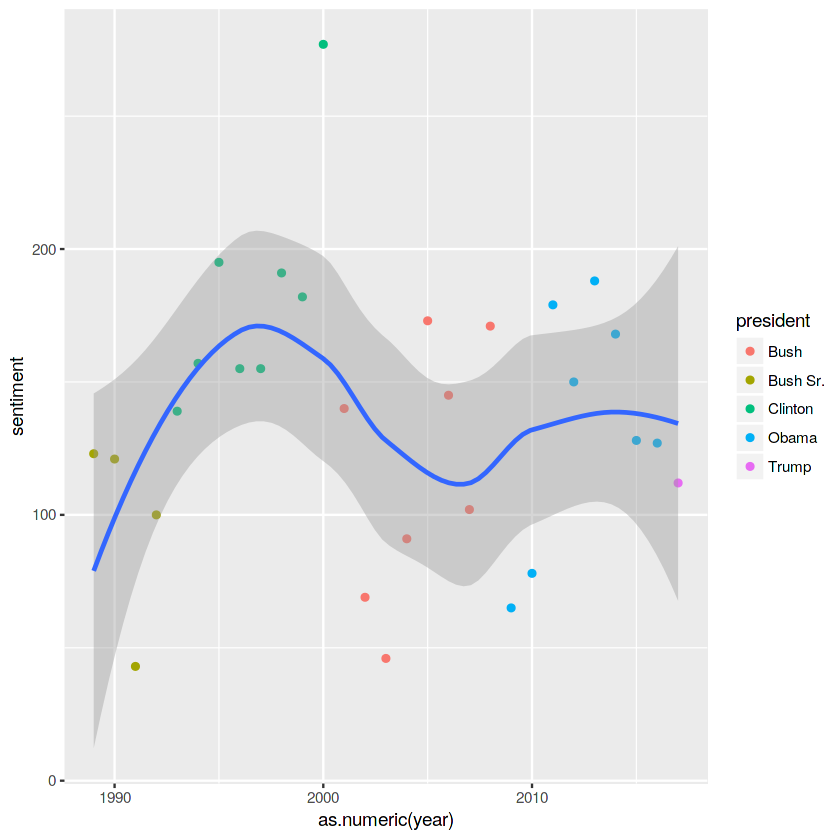

In [6]:
# plot of sentiment over time & automatically choose a method to model the change
ggplot(sentiments, aes(x = as.numeric(year), y = sentiment)) + 
  geom_point(aes(color = president))+ # add points to our plot, color-coded by president
  geom_smooth(method = "auto") # pick a method & fit a model

While it looks like there haven't been any strong trends over time, the line above suggests that presidents from the Democratic party (Clinton and Obama) have a slightly more positive sentiment than presidents from the Republican party (Bush Sr., Bush and Trump).  Let's look at individual presidents and see if that pattern holds:

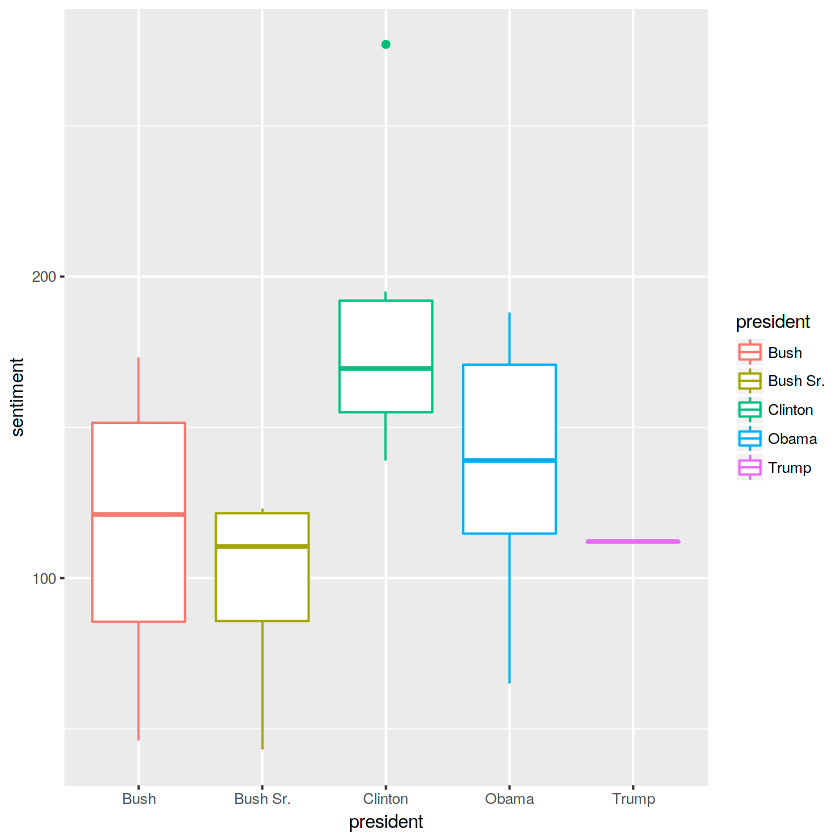

In [7]:
# plot of sentiment by president
ggplot(sentiments, aes(x = president, y = sentiment, color = president)) + 
  geom_boxplot() # draw a boxplot for each president

It looks like this is a pretty strong pattern. Let's directly compare the two parties to see if there's a reliable difference between them. We'll need to manually label which presidents were Democratic and which were Republican and then test to see if there's a difference in their sentiment scores.

Warning message in president == c("Clinton", "Obama"):
“longer object length is not a multiple of shorter object length”Joining, by = c("negative", "positive", "sentiment", "file", "year", "president", "party")



	Welch Two Sample t-test

data:  democrats$sentiment and republicans$sentiment
t = 2.2442, df = 16.606, p-value = 0.03876
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  2.256549 75.320374
sample estimates:
mean of x mean of y 
 149.2500  110.4615 


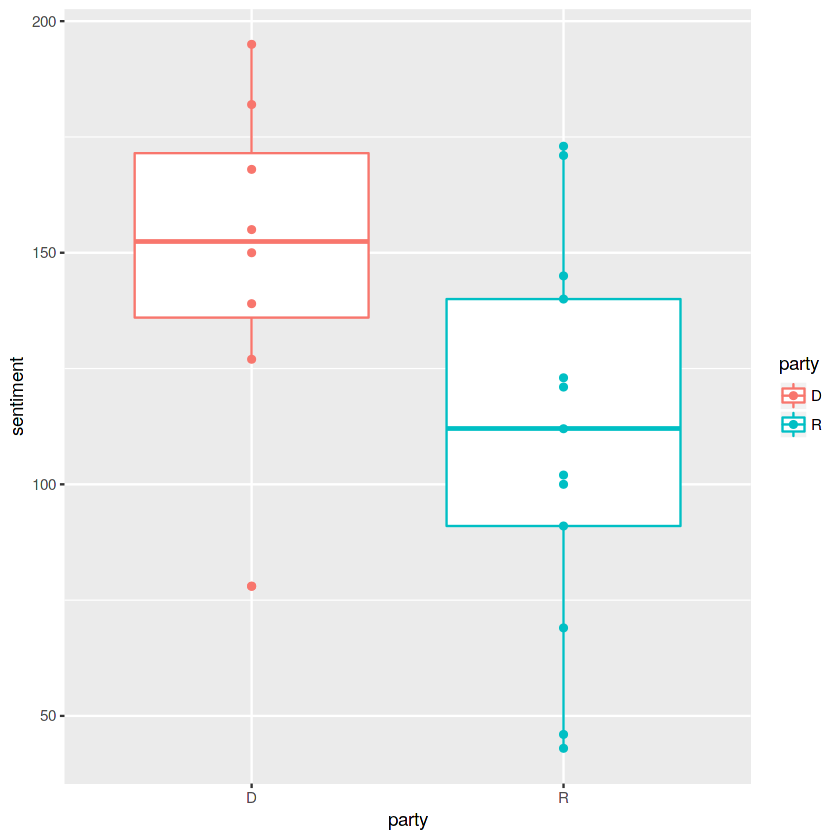

In [8]:
# is the difference between parties significant?
# get democratic presidents & add party affiliation
democrats <- sentiments %>%
    filter(president == c("Clinton","Obama")) %>%
    mutate(party = "D")

# get democratic presidents & party add affiliation
republicans <- sentiments %>%
    filter(president != "Clinton" & president != "Obama") %>%
    mutate(party = "R")

# join both
byParty <- full_join(democrats, republicans)

# the difference between the parties is significant
t.test(democrats$sentiment, republicans$sentiment)

# plot sentiment by party
ggplot(byParty, aes(x = party, y = sentiment, color = party)) + geom_boxplot() + geom_point()

So it looks like there is a reliable difference in the sentiment of the State of the Union addresses given by Democratic and Republican presidents, at least from 1989 to 2017. 

There a couple things to keep in mind with this analysis, though: 

* We didn't correct for the length of the documents. It could be that the State of the Union addresses from Democratic presidents have more positive words because they are longer rather than becuase they are more positive.
* We're using a general-purpose list of words rather than one specifically designed for analyzing political language. Furthermore, we only used one sentiment analysis list. 